In [1]:
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
class ShipClassifier:
    def __init__(self, pretrained=True):
        self.model = None
        self.create_model(pretrained)
        
    def create_model(self, pretrained=True):
        """
        Crea una EfficientNet para la clasificacion de barcos
        
        Args:
            pretrained (bool): usar preentrenamiento o no
        """

        model = models.efficientnet_b0(pretrained=pretrained)
        
        # SEGUN EL PREENTRENAMIENTO QUE HAGAMOS TENEMOS QUE CAMBIAR LA CAPA ORIGINAL
        # original_conv = model.features[0][0]
        # model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # En esta implementacion congelamos los pesos para hacer transfer learning
        #for param in model.features.parameters():
        #    param.requires_grad = False
        # Usar el preentrenamiento
        # if pretrained:
        #     with torch.no_grad():
        #         # Average the weights across the 3 RGB channels to create weights for 1 channel
        #         model.features[0][0].weight.data = original_conv.weight.data.sum(dim=1, keepdim=True)
        
        # Modificamos para usar dos clases (barco/no barco)
        model.classifier[1] = nn.Linear(in_features=1280, out_features=2)
        
        self.model = model
        return model

    def train_model(self, train_loader, optimizer=None, criterion=None, num_epochs=3, patience=2):
        """
        Entrena el modelo de clasificacion binaria de barcos

        Args:
            train_loader: DataLoader para los datos de entrenamiento
            optimizer: PyTorch optimizer, Adam por defecto 
            criterion: Loss function, CrossEntropyLoss por defecto
            num_epochs (int): Numero de epochs de entrenamiento
            patience (int): Paciencia del Early Stopping
            
        Returns:
            model: Modelo entrenado
            history: Diccionario con las metricas del modelo
        """
        if self.model is None:
            return "Please create a model (ShipClassifier.create_model()) before training"
        if optimizer is None:
            optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        if criterion is None:
            criterion = nn.CrossEntropyLoss()
            
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # print(f"Using device: {'GPU' if device == torch.device('cuda:0') else 'CPU'}")    

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {'MPS' if device.type == 'mps' else 'CPU'}")

        self.model.to(device)
        scaler = GradScaler()
     
        # History for metrics
        history = {
            'train_loss': [],         # Perdida por Batch
            'train_acc': [],          # Accuracy por Batch
            'epoch_train_loss': [],   # Avg loss por Epoch
            'epoch_train_acc': [],    # Avg accuracy por Epoch
            'training_time': 0.0      # Total training time
        }

        best_loss = np.inf  
        epochs_no_improve = 0       

        start_time = time.time()
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Training mode
            self.model.train()
            current_loss = 0.0
            current_corrects = 0
            total_samples = 0
            
            for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Reiniciar los gradientes
                optimizer.zero_grad()
                
                # Forward
                if device.type == 'cuda':
                    with autocast(device_type='cuda'): 
                        outputs = self.model(inputs)
                        loss = criterion(outputs, labels)  # Calculo de loss
                else:
                    outputs = self.model(inputs) 
                    loss = criterion(outputs, labels)  # Calculo de loss
                
                # Backward + optimize
                scaler.scale(loss).backward()  # Escalar gradientes
                scaler.step(optimizer)  # Actualizar pesos
                scaler.update()  # Actualizar el escalador
                
                # Loss y Accuracy del Batch 
                history['train_loss'].append(loss.item())
                
                # Calcular accuracy
                _, predicted = torch.max(outputs, 1)
                batch_acc = torch.sum(predicted == labels.data) / inputs.size(0)
                history['train_acc'].append(batch_acc.item())
                
                # Acumular estadisitcas
                current_loss += loss.item() * inputs.size(0)  
                current_corrects += torch.sum(predicted == labels.data)  
                total_samples += inputs.size(0)
                
                if i % 100 == 0:
                    print(f"  Batch {i}: Loss: {loss.item():.4f}, Acc: {batch_acc.item():.4f}")
            
            # Estadisiticas por epoch
            epoch_loss = current_loss / total_samples
            epoch_acc = current_corrects / total_samples
            
            history['epoch_train_loss'].append(epoch_loss)
            history['epoch_train_acc'].append(epoch_acc.item())
            
            print(f'  Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Early stopping
            if epoch_loss < best_loss:
                best_loss = epoch_loss  
                epochs_no_improve = 0  
            else:
                epochs_no_improve += 1 
                print(f'  No improvement in loss for {epochs_no_improve} epochs.')
                
                if epochs_no_improve >= patience:
                    print(f'  Early stopping triggered after {epoch+1} epochs.')
                    break

        # Total training time
        time_elapsed = time.time() - start_time
        history['training_time'] = time_elapsed

        print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Final Accuracy: {epoch_acc:.4f}')

        return self.model, history

    def test_model(self, test_loader):
        """
        Evalua el modelo con un conjunto de entrenamiento
        
        Args:
            test_loader: DataLoader para los datos de entrenamiento
            
        Returns:
            test_acc: Test accuracy
            test_accuracies: Accuracy por Batch
            f1: F1 score
        """

        if self.model is None:
            return "Please create a model (ShipClassifier.create_model()) before training"

        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        print(f"Using device: {'MPS' if device.type == 'mps' else 'CPU'}")

        self.model.to(device)  
        self.model.eval()  # Poner el modelo en modo evaluacion
        
        running_corrects = 0
        total_samples = 0
        test_accuracies = []
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Evaluating"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                batch_acc = torch.sum(preds == labels.data) / inputs.size(0)
                test_accuracies.append(batch_acc.item())
                
                # Guardar predicciones para calcular la F1-Score
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
       
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

        test_acc = running_corrects / total_samples
        print(f'Test Accuracy: {test_acc:.4f}')
        f1 = f1_score(all_labels, all_preds, average='macro')
        print(f'F1 Score: {f1:.4f}')
        return test_acc.item(), test_accuracies, f1
    
    def save_model(self, path="modelParams"):
        """
        Guarda el modelo en disco
        
        Args:
            path: direccion para guardar el modelo
        """
        if self.model is None:
            return "Please create a model (ShipClassifier.create_model()) before training"

        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")
        
    def load_model(self, path="modelParams"):
        """
        Carga el modelo desde disco
        
        Args:
            path: direcion donde se encuentra el modelo
        """
        if self.model is None:
            return "Please create a model (ShipClassifier.create_model()) before training"

        self.model.load_state_dict(torch.load(path))
        print(f"Model loaded from {path}")
        
    def plot_metrics(self, history, test_acc):
        '''
        Grafica los resultados del entrenamiento y test
        
        Args:
            history: diccionario con las metricas a graficar
            test_acc: ultimo valor de accuracy en el test
        '''
        plt.figure(figsize=(12, 5))

        # Gráfico de pérdida
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.title('Loss')
        plt.xlabel('Época')
        plt.ylabel('Pérdida')
        plt.legend()

        # Gráfico de precisión
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
        plt.title('Accuracy')
        plt.xlabel('Época')
        plt.ylabel('Precisión')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [92]:
class RandomLargestSquareCrop(object):
    def __init__(self):
        pass
    def __call__(self, img):

        width, height = img.size
        min_dim = min(width, height)
        
        if width > height:
            left = random.randint(0, width - min_dim)
            top = 0
        elif height > width:
            left = 0
            top = random.randint(0, height - min_dim)
        else:
            left = 0
            top = 0
        
        img = img.crop((left, top, left + min_dim, top + min_dim))
        
        return img


class ShipDataset(Dataset):
    def __init__(self, root_dir, train=True, dataAugmentation=False, docked=False, transform=None, train_ratio=0.8):
        """
        Args:
            root_dir (string): Directory containing the image folders
            dataAugmentation (bool): Whether to apply data augmentation and include cropped ship images
            docked (bool): Whether to include docked status in labels
            transform (callable, optional): Optional additional transform to be applied
        """
        self.root_dir = root_dir
        self.train = train
        self.dataAugmentation = dataAugmentation
        self.docked = docked
        self.base_transform = transforms.Compose([
            RandomLargestSquareCrop(),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.augmentation_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),    
            transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=2),
            transforms.GaussianBlur(kernel_size=3, sigma=(1, 1)),
            transforms.RandomGrayscale(p=0.15),  # 10% chance to apply grayscale
        ])

        self.crop_transform = transforms.Compose([

            RandomLargestSquareCrop(),
            transforms.Resize((350,350)),
            transforms.RandomCrop(224),  # Adjust size as needed
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.additional_transform = transform

        # Collect image paths and labels
        self.images = []
        self.labels = []

        # 1. No-ship images (images/ns-xxx.jpg)
        no_ship_dir = os.path.join(root_dir, "images")
        for filename in os.listdir(no_ship_dir):
            if filename.startswith("ns-") and filename.endswith(".jpg"):
                img_path = os.path.join(no_ship_dir, filename)
                if self.docked:
                    self.images.append((img_path, "no_ship"))
                    self.labels.append((0, 0))
                else:
                    self.images.append((img_path, "no_ship"))
                    self.labels.append(0)

        # 2. Cropped-ship images (only if dataAugmentation is True)
        if self.dataAugmentation:
            cropped_dir = os.path.join(root_dir, "cropedImages")
            for filename in os.listdir(cropped_dir):
                if filename.startswith("s-") and filename.endswith(".jpg"):
                    img_path = os.path.join(cropped_dir, filename)
                    if self.docked:
                        is_docked = 1 if "docked" in filename else 0
                        self.images.append((img_path, "cropped_ship"))
                        self.labels.append((1, is_docked))
                    else:
                        self.images.append((img_path, "cropped_ship"))
                        self.labels.append(1)

        # 3. Regular ship images (images/s-xxx-docked.jpg)
        if not self.dataAugmentation:
            for filename in os.listdir(no_ship_dir):
                if filename.startswith("s-") and filename.endswith(".jpg"):
                    img_path = os.path.join(no_ship_dir, filename)
                    if self.docked:
                        is_docked = 1 if "docked" in filename else 0
                        self.images.append((img_path, "regular_ship"))
                        self.labels.append((1, is_docked))
                    else:
                        self.images.append((img_path, "regular_ship"))
                        self.labels.append(1)

        no_ship_count = sum(1 for img, type in self.images if type == "no_ship")
        cropped_ship_count = sum(1 for img, type in self.images if type == "cropped_ship")
        regular_ship_count = sum(1 for img, type in self.images if type == "regular_ship")
        
        no_ship_split = int(no_ship_count * train_ratio)
        cropped_ship_split = int(cropped_ship_count * train_ratio)
        regular_ship_split = int(regular_ship_count * train_ratio)
        
        # Create indices for each category
        no_ship_indices = [i for i, (_, type) in enumerate(self.images) if type == "no_ship"]
        cropped_ship_indices = [i for i, (_, type) in enumerate(self.images) if type == "cropped_ship"]
        regular_ship_indices = [i for i, (_, type) in enumerate(self.images) if type == "regular_ship"]
        
        # Select validation indices
        if self.train:
            no_ship_indices = no_ship_indices[:no_ship_split]
            cropped_ship_indices = cropped_ship_indices[:cropped_ship_split]
            regular_ship_indices = regular_ship_indices[:regular_ship_split]
        else:
            no_ship_indices = no_ship_indices[no_ship_split:]
            cropped_ship_indices = cropped_ship_indices[cropped_ship_split:]
            regular_ship_indices = regular_ship_indices[regular_ship_split:]
        
        # Combine all indices
        valid_indices = no_ship_indices + cropped_ship_indices + regular_ship_indices
        
        # Filter images and labels
        self.images = [self.images[i] for i in valid_indices]
        self.labels = [self.labels[i] for i in valid_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, img_type = self.images[idx]
        label = self.labels[idx]

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply appropriate transforms
        if self.dataAugmentation:
            if img_type == "no_ship" or img_type == "regular_ship":
                # Apply crop transform for no-ship and regular-ship images
                image = self.crop_transform(self.augmentation_transform(image))
            else:
                # Cropped ship images already processed
                image = self.base_transform(self.augmentation_transform(image))
        else:
            # No data augmentation, just apply base transform
            image = self.base_transform(image)

        # Apply any additional transforms if provided
        if self.additional_transform:
            image = self.additional_transform(image)

        return image, label

In [19]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet B0 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# los dejo por tener ahi
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                       download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                      download=True, transform=transform)

dataAugmentation = True

trainset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=True, dataAugmentation=dataAugmentation)
testset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=False, dataAugmentation=dataAugmentation)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

classifier = ShipClassifier(pretrained=True)
# Guardar el modelo
if classifier.model is None:
    print("Error: Model was not created properly.")
    classifier.create_model(pretrained=True)
    
    if classifier.model is None:
        print("Error: Failed to create model. Exiting.")
        exit(1)

# Modificar para CIFAR10 la capa de salida
classifier.model.classifier[1] = nn.Linear(in_features=1280, out_features=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([param for param in classifier.model.parameters() if param.requires_grad], 
                      lr=0.001, momentum=0.9)

model, history = classifier.train_model(
    train_loader=trainloader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=8,
    patience=3
)

test_acc, test_accuracies, f1 = classifier.test_model(testloader)
classifier.plot_metrics(history, test_acc)
classifier.save_model("modelParams")

/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: MPS


/Users/pepe/carrera/3/2/vca/vca/lib/python3.13/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Epoch 1/8
----------


Python(57402) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(57403) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=79, pipe_handle=116)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=79, pipe_handle=123)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3

RuntimeError: DataLoader worker (pid(s) 57402, 57403) exited unexpectedly

In [51]:
import matplotlib.pyplot as plt
from numpy import random


def plotgrid(trainset, cols=8, rows=4):
    cols, rows = 8, 4
    figure = plt.figure(figsize=(cols*2, rows*2))
    view = random.permutation(cols * rows)
    
    for i, j in zip(range(1, cols * rows + 1), np.random.choice(np.arange(len(trainset)),cols * rows)):
        sample, label = trainset[-i]
        sample = torch.Tensor.permute(sample,(1,2,0)).numpy()
        sample -= np.min(sample)
        sample /= np.max(sample)
        figure.add_subplot(rows, cols, i)
        plt.title(f'Clase {label}')
        plt.axis("off")
        plt.imshow(sample, cmap="gray")
    plt.show();
    
    cols, rows = 8, 4
    figure = plt.figure(figsize=(cols*2, rows*2))
    view = random.permutation(cols * rows)
    
    for i, j in zip(range(1, cols * rows + 1), np.random.choice(np.arange(len(trainset)),cols * rows)):
        sample, label = trainset[i]
        sample = torch.Tensor.permute(sample,(1,2,0)).numpy()
        sample -= np.min(sample)
        sample /= np.max(sample)
        figure.add_subplot(rows, cols, i)
        plt.title(f'Clase {label}')
        plt.axis("off")
        plt.imshow(sample, cmap="gray")
    plt.show();

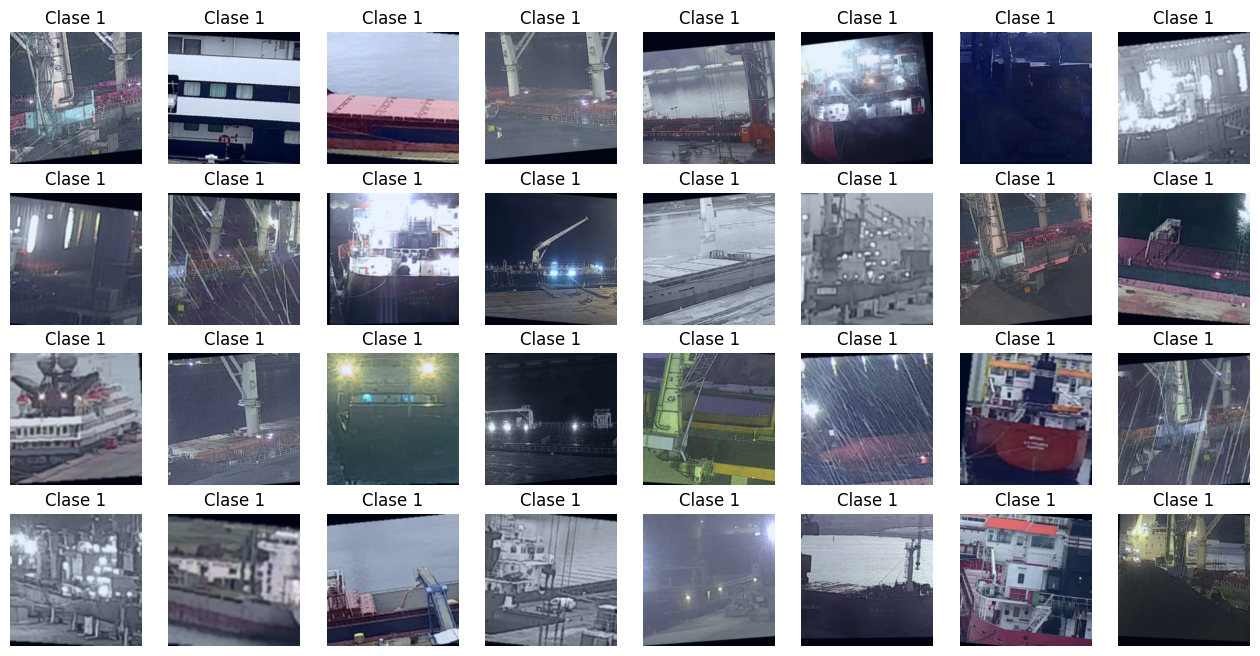

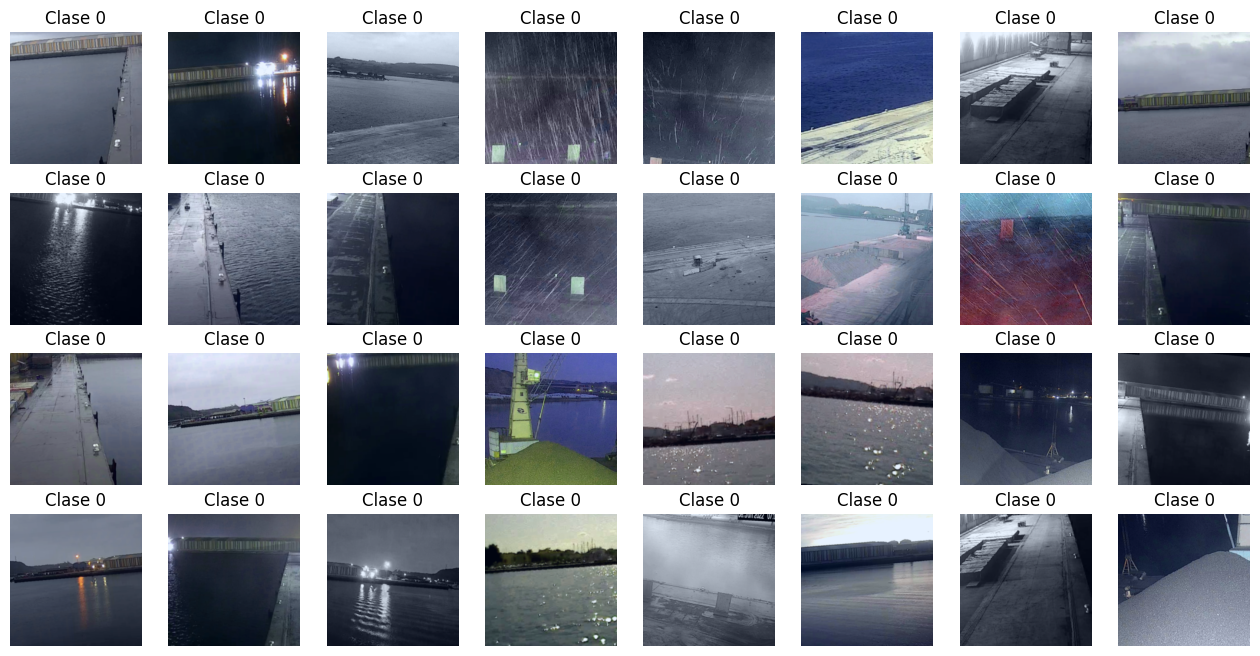

In [93]:
dataAugmentation = True

trainset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=True, dataAugmentation=dataAugmentation)
testset = ShipDataset(root_dir='/Users/pepe/carrera/3/2/vca/practicas/p2', train=False, dataAugmentation=dataAugmentation)

plotgrid(trainset)